In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Data cleaning

As the images I use do not have the consistent name convention, I will to change it. 

In [2]:
paths = ['dataset/incorrect_mask', 'dataset/with_mask', 'dataset/without_mask']
for path in paths:
    i = 0
    for filename in os.listdir(path):
        os.rename(os.path.join(path,filename), os.path.join(path, str(i)+'.jpg'))
        i = i + 1

## Load the exemplary image

In [49]:
img_example = cv.imread('dataset/without_mask/0.jpg')
img_example1 = cv.imread('dataset/with_mask/0-with-mask.jpg')

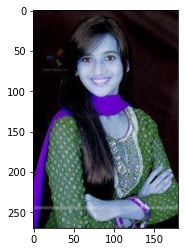

In [50]:
plt.imshow(img_example)

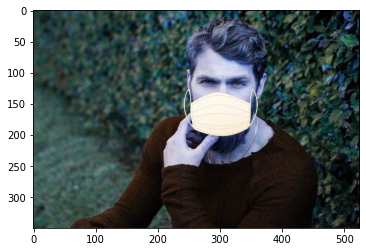

In [51]:
plt.imshow(img_example1)

As can be seen, the colors are probably swapped - matplotlib and openCV have different color channels order. Therefore, for the display purposes, I use a function that will correct the displayed image.

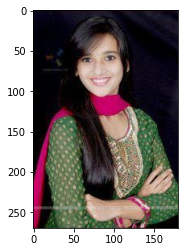

In [70]:
img_display = cv.cvtColor(img_example, cv.COLOR_BGR2RGB)
plt.imshow(img_display)

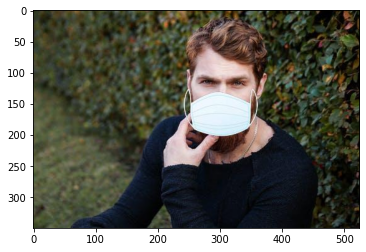

In [69]:
img_display1 = cv.cvtColor(img_example1, cv.COLOR_BGR2RGB)
plt.imshow(img_display1)

That is much better. Now I can go on and apply face detection - there is no need to look for a face mask beyond this region after all: this way, after the model detects the face, I can crop the image before giving in to the mask detection model, which will speed up its execution time.

## Face detection

For this task, I will use Cascade classifier provided by openCV, as well as their frontal face d. To actually use this, I have to convert my image to the greyscale.

In [55]:
img_gray1 = cv.cvtColor(img_example1, cv.COLOR_BGR2GRAY)
img_gray = cv.cvtColor(img_example, cv.COLOR_BGR2GRAY)

In [20]:
face_detector = cv.CascadeClassifier('dataset/haarcascade_frontalface_default.xml')

In [56]:
faces1 = face_detector.detectMultiScale(img_gray1, scaleFactor = 1.2, minNeighbors = 5)
faces = face_detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
faces

array([[49, 36, 68, 68]], dtype=int32)

The detector foun a face and its coordinates on the image. Let's see where it lies:

In [72]:
for (a, b, c, d) in faces:
    crop_img = img_display[b:b+d, a:a+c]
    cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
for (a, b, c, d) in faces1:
    crop_img1 = img_display1[b:b+d, a:a+c]
    cv.rectangle(img_display1, (a, b), (a+c, b+d), (0, 0, 255), 2)

That should do it. Let's display the image:

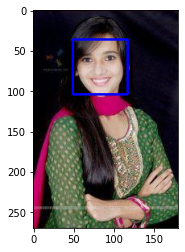

In [58]:
plt.imshow(img_display)

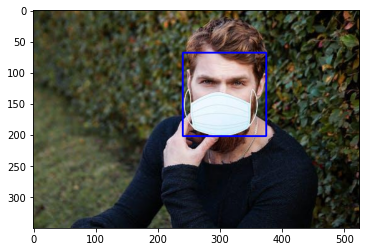

In [59]:
plt.imshow(img_display1)

I used the blue frame as it have not checked the appearance of the mask yet. Well, I can crop it already in fact. I did it for the display photos during the rectangle addition so that I wouldn't have to loop through the coordinates again.

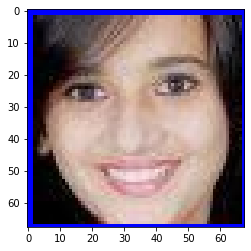

In [73]:
plt.imshow(crop_img)

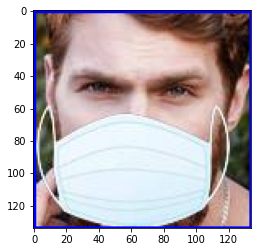

In [74]:
plt.imshow(crop_img1)

Wonderful! I now habve smaller regions to take care of. However, I shall rescale them before forwarding them into the next model.